In [1]:
import pandas as pd
import numpy as np

from functools import reduce

from sqlalchemy import create_engine

from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

- Need to get users and their interactions so that I can
    - Group by the user ages/user tenure and interaction type

- Need to analyze how these different groups approach the different types of offers
    - Are they more likely to complete an offer

- Need to analyze which offers are more likely to be completed

# Loading data

In [2]:
conn = create_engine('sqlite:///data/raw_starbucks.db')

# offers.to_sql('offers', conn, if_exists='replace', index=False)
# users.to_sql('users', conn, if_exists='replace', index=False)
# interactions.to_sql('interactions', conn, if_exists='replace', index=False)

offers = pd.read_sql('SELECT * FROM offers', conn)

users = pd.read_sql('SELECT * FROM users', conn)
users['user_age_group'] = users['user_age_group'].fillna('Unknown')
users['user_age_group'] = users['user_age_group'].astype(str)
categories = ['Unknown'] + sorted(users['user_age_group'].unique().tolist())[:-1]
users['user_age_group'] = pd.Categorical(users['user_age_group'], categories=categories, ordered=True)

interactions = pd.read_sql('SELECT * FROM interactions', conn)

# User and interactions

In [3]:
display(users.head())

,user_id,user_gender,user_age,user_member_since,user_income,user_tenure,user_age_group
0,68be06ca386d4c31939f3a4f0e3dd783,None,NaN,2017-02-12 00:00:00.000000,NaN,1,Unknown
1,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15 00:00:00.000000,112000.0,1,56-65
2,38fe809add3b4fcf9315a9694bb96ff5,None,NaN,2018-07-12 00:00:00.000000,NaN,0,Unknown
3,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09 00:00:00.000000,100000.0,1,66+
4,a03223e636434f42ac4c3df47e8bac43,None,NaN,2017-08-04 00:00:00.000000,NaN,1,Unknown


In [4]:
display(interactions.head())

,user_id,intxn_event_type,intxn_time,intxn_amount,offer_id,intxn_reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [5]:
display( interactions[ (interactions['intxn_event_type'] == 'transaction') & (~interactions['offer_id'].isna()) ] )

,user_id,intxn_event_type,intxn_time,intxn_amount,offer_id,intxn_reward


In [6]:
users_interactions = pd.merge(users, interactions, on='user_id', how='inner')

display(users_interactions.head())

,user_id,user_gender,user_age,user_member_since,user_income,user_tenure,user_age_group,intxn_event_type,intxn_time,intxn_amount,offer_id,intxn_reward
0,68be06ca386d4c31939f3a4f0e3dd783,None,NaN,2017-02-12 00:00:00.000000,NaN,1,Unknown,offer received,168,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
1,68be06ca386d4c31939f3a4f0e3dd783,None,NaN,2017-02-12 00:00:00.000000,NaN,1,Unknown,offer viewed,216,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
2,68be06ca386d4c31939f3a4f0e3dd783,None,NaN,2017-02-12 00:00:00.000000,NaN,1,Unknown,offer received,336,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
3,68be06ca386d4c31939f3a4f0e3dd783,None,NaN,2017-02-12 00:00:00.000000,NaN,1,Unknown,offer viewed,348,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
4,68be06ca386d4c31939f3a4f0e3dd783,None,NaN,2017-02-12 00:00:00.000000,NaN,1,Unknown,transaction,360,0.35,None,NaN


In [7]:
intxtn_by_age_group = users_interactions.groupby(['user_age_group', 'intxn_event_type'], dropna=False, observed=False).count()['user_id'].reset_index().rename( columns={'user_id':'count'} )

display(intxtn_by_age_group)

,user_age_group,intxn_event_type,count
0,Unknown,offer completed,1135
1,Unknown,offer received,9776
2,Unknown,offer viewed,7865
3,Unknown,transaction,14996
4,19-25,offer completed,1466
5,19-25,offer received,3938
6,19-25,offer viewed,2721
7,19-25,transaction,8929
8,26-35,offer completed,2477
9,26-35,offer received,6228


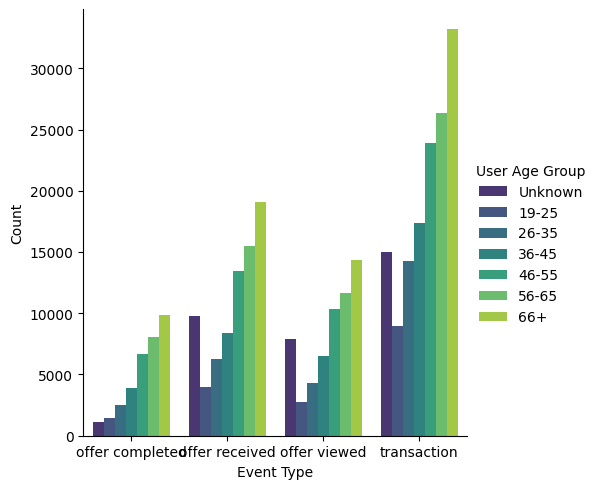

In [8]:
event_type_by_age_group_chart = sns.catplot(
    data=intxtn_by_age_group, kind='bar',
    x='intxn_event_type', y='count', 
    hue='user_age_group', 
    height=5, palette='viridis'
)

event_type_by_age_group_chart.set_axis_labels( 'Event Type', 'Count' )
sns.move_legend(event_type_by_age_group_chart, loc='center right', title='User Age Group')

1. Need to try and find out how many users have a transaction after receiving/viewing an offer
2. Need to try and find out how many users have a transaction without a prior offer

In [9]:
offer_received = interactions[ interactions['intxn_event_type'] == 'offer received' ].copy().drop(['intxn_amount', 'intxn_reward'], axis=1)
offer_received_cols = [ "received" + cn.removeprefix('intxn') if 'intxn' in cn else cn for cn in offer_received.columns ]
offer_received.columns = offer_received_cols

offer_viewed = interactions[ interactions['intxn_event_type'] == 'offer viewed' ].copy().drop(['intxn_amount', 'intxn_reward'], axis=1)
offer_viewed_cols = [ "viewed" + cn.removeprefix('intxn') if 'intxn' in cn else cn for cn in offer_viewed.columns ]
offer_viewed.columns = offer_viewed_cols

offer_completed = interactions[ interactions['intxn_event_type'] == 'offer completed' ].copy().drop(['intxn_amount'], axis=1)
offer_completed_cols = [ "completed" + cn.removeprefix('intxn') if 'intxn' in cn else cn for cn in offer_completed.columns ]
offer_completed.columns = offer_completed_cols

transactions = interactions[ interactions['intxn_event_type'] == 'transaction' ].copy().drop(['offer_id', 'intxn_reward'], axis=1)
transactions_cols = [ "transaction" + cn.removeprefix('intxn') if 'intxn' in cn else cn for cn in transactions.columns ]
transactions.columns = transactions_cols


In [10]:
offers

,offer_id,offer_notification_channel,offer_type,offer_spend_minimum,offer_reward,offer_duration
0,ae264e3637204a6fb9bb56bc8210ddfd,email,bogo,10,10,168
1,ae264e3637204a6fb9bb56bc8210ddfd,mobile,bogo,10,10,168
2,ae264e3637204a6fb9bb56bc8210ddfd,social,bogo,10,10,168
3,4d5c57ea9a6940dd891ad53e9dbe8da0,web,bogo,10,10,120
4,4d5c57ea9a6940dd891ad53e9dbe8da0,email,bogo,10,10,120
5,4d5c57ea9a6940dd891ad53e9dbe8da0,mobile,bogo,10,10,120
6,4d5c57ea9a6940dd891ad53e9dbe8da0,social,bogo,10,10,120
7,3f207df678b143eea3cee63160fa8bed,web,informational,0,0,96
8,3f207df678b143eea3cee63160fa8bed,email,informational,0,0,96
9,3f207df678b143eea3cee63160fa8bed,mobile,informational,0,0,96


In [43]:
offers_for_joining = offers.drop('offer_notification_channel', axis=1).drop_duplicates()

offer_journey = pd.merge( offers_for_joining, offer_received, on=['offer_id'], how='outer' )
offer_journey = pd.merge( offer_journey, offer_viewed, on=['offer_id', 'user_id'], how='outer' )
offer_journey = pd.merge( offer_journey, offer_completed, on=['offer_id', 'user_id'], how='outer' )
offer_journey = pd.merge( offer_journey, transactions, on=['user_id'], how='outer' )
offer_journey = offer_journey.drop_duplicates()

display(offer_journey)

,offer_id,offer_type,offer_spend_minimum,offer_reward,offer_duration,user_id,received_event_type,received_time,viewed_event_type,viewed_time,completed_event_type,completed_time,completed_reward,transaction_event_type,transaction_time,transaction_amount
0,2906b810c7d4411798c6938adc9daaa5,discount,10.0,2.0,168.0,0009655768c64bdeb2e877511632db8f,offer received,576.0,NaN,NaN,offer completed,576.0,2.0,transaction,228.0,22.16
1,2906b810c7d4411798c6938adc9daaa5,discount,10.0,2.0,168.0,0009655768c64bdeb2e877511632db8f,offer received,576.0,NaN,NaN,offer completed,576.0,2.0,transaction,414.0,8.57
2,2906b810c7d4411798c6938adc9daaa5,discount,10.0,2.0,168.0,0009655768c64bdeb2e877511632db8f,offer received,576.0,NaN,NaN,offer completed,576.0,2.0,transaction,528.0,14.11
3,2906b810c7d4411798c6938adc9daaa5,discount,10.0,2.0,168.0,0009655768c64bdeb2e877511632db8f,offer received,576.0,NaN,NaN,offer completed,576.0,2.0,transaction,552.0,13.56
4,2906b810c7d4411798c6938adc9daaa5,discount,10.0,2.0,168.0,0009655768c64bdeb2e877511632db8f,offer received,576.0,NaN,NaN,offer completed,576.0,2.0,transaction,576.0,10.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035301,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,2.0,240.0,ffff82501cea40309d5fdd7edcca4a07,offer received,0.0,offer viewed,6.0,offer completed,60.0,2.0,transaction,498.0,13.17
1035302,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,2.0,240.0,ffff82501cea40309d5fdd7edcca4a07,offer received,0.0,offer viewed,6.0,offer completed,60.0,2.0,transaction,504.0,7.79
1035303,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,2.0,240.0,ffff82501cea40309d5fdd7edcca4a07,offer received,0.0,offer viewed,6.0,offer completed,60.0,2.0,transaction,576.0,14.23
1035304,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,2.0,240.0,ffff82501cea40309d5fdd7edcca4a07,offer received,0.0,offer viewed,6.0,offer completed,60.0,2.0,transaction,606.0,10.12


- Need to account for customers that have not even received an offer, but they have a transaction

In [45]:
display( offer_journey[ ( offer_journey['received_time'].isna() ) & ( ~offer_journey['transaction_time'].isna() ) ] )

,offer_id,offer_type,offer_spend_minimum,offer_reward,offer_duration,user_id,received_event_type,received_time,viewed_event_type,viewed_time,completed_event_type,completed_time,completed_reward,transaction_event_type,transaction_time,transaction_amount
75159,NaN,NaN,NaN,NaN,NaN,12ede229379747bd8d74ccdc20097ca3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,transaction,18.0,16.62
75160,NaN,NaN,NaN,NaN,NaN,12ede229379747bd8d74ccdc20097ca3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,transaction,324.0,27.60
75161,NaN,NaN,NaN,NaN,NaN,12ede229379747bd8d74ccdc20097ca3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,transaction,654.0,19.03
236610,NaN,NaN,NaN,NaN,NaN,3a4874d8f0ef42b9a1b72294902afea9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,transaction,324.0,22.75
236611,NaN,NaN,NaN,NaN,NaN,3a4874d8f0ef42b9a1b72294902afea9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,transaction,378.0,27.20
236612,NaN,NaN,NaN,NaN,NaN,3a4874d8f0ef42b9a1b72294902afea9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,transaction,576.0,17.67
702703,NaN,NaN,NaN,NaN,NaN,ae8111e7e8cd4b60a8d35c42c1110555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,transaction,306.0,17.51
702704,NaN,NaN,NaN,NaN,NaN,ae8111e7e8cd4b60a8d35c42c1110555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,transaction,330.0,28.70
702705,NaN,NaN,NaN,NaN,NaN,ae8111e7e8cd4b60a8d35c42c1110555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,transaction,444.0,11.53
702706,NaN,NaN,NaN,NaN,NaN,ae8111e7e8cd4b60a8d35c42c1110555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,transaction,636.0,9.72


In [41]:
# Since the join above was done lazily, need to remove rows where the coupon was viewed before the received time since that shouldn't be possible
# Also removing rows where the coupon was viewed after the end of the offer duration since whether they are valid or not, they are not valid for our analysis
offer_journey = offer_journey[ ( ( offer_journey['received_time'] <= offer_journey['viewed_time'] ) & ( offer_journey['viewed_time'] < offer_journey['received_time'] + offer_journey['offer_duration'] ) ) | ( offer_journey['viewed_time'].isna() ) ]
# Removing rows where the viewed time was after the completed time since that shouldn't be possible
offer_journey = offer_journey[ ( offer_journey['viewed_time'] <= offer_journey['completed_time'] ) | ( offer_journey['viewed_time'].isna() ) ]
# Removing rows where the offer completed is before the offer received since that shouldn't be possible
offer_journey = offer_journey[ offer_journey['received_time'] <= offer_journey['completed_time'] ]
# Removing rows where the completed time is not equal to the transaction time since that shouldn't be possible
offer_journey = offer_journey[ ( ( offer_journey['completed_time'] == offer_journey['transaction_time'] ) & ( offer_journey['completed_time'] <= offer_journey['received_time'] + offer_journey['offer_duration'] ) ) | ( offer_journey['received_time'].isna() ) ]

offer_journey = offer_journey \
                .drop_duplicates() \
                .sort_values(by=['user_id', 'offer_id']) \
                .reset_index( drop=True ) \
                .drop_duplicates(subset=['offer_id', 'user_id', 'transaction_time'], keep='last')

display(offer_journey)

,offer_id,offer_type,offer_spend_minimum,offer_reward,offer_duration,user_id,received_event_type,received_time,viewed_event_type,viewed_time,completed_event_type,completed_time,completed_reward,transaction_event_type,transaction_time,transaction_amount
0,2906b810c7d4411798c6938adc9daaa5,discount,10.0,2.0,168.0,0009655768c64bdeb2e877511632db8f,offer received,576.0,NaN,NaN,offer completed,576.0,2.0,transaction,576.0,10.27
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20.0,5.0,240.0,0011e0d4e6b944f998e987f904e8c1e5,offer received,408.0,offer viewed,432.0,offer completed,576.0,5.0,transaction,576.0,22.05
2,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7.0,3.0,168.0,0011e0d4e6b944f998e987f904e8c1e5,offer received,168.0,offer viewed,186.0,offer completed,252.0,3.0,transaction,252.0,11.93
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,5.0,168.0,0011e0d4e6b944f998e987f904e8c1e5,offer received,504.0,offer viewed,516.0,offer completed,576.0,5.0,transaction,576.0,22.05
4,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10.0,10.0,120.0,0020c2b971eb4e9188eac86d93036a77,offer received,408.0,offer viewed,426.0,offer completed,510.0,10.0,transaction,510.0,17.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30112,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20.0,5.0,240.0,ffff82501cea40309d5fdd7edcca4a07,offer received,168.0,offer viewed,174.0,offer completed,198.0,5.0,transaction,198.0,22.88
30113,2906b810c7d4411798c6938adc9daaa5,discount,10.0,2.0,168.0,ffff82501cea40309d5fdd7edcca4a07,offer received,336.0,offer viewed,354.0,offer completed,384.0,2.0,transaction,384.0,15.57
30116,2906b810c7d4411798c6938adc9daaa5,discount,10.0,2.0,168.0,ffff82501cea40309d5fdd7edcca4a07,offer received,408.0,offer viewed,414.0,offer completed,414.0,2.0,transaction,414.0,17.55
30117,2906b810c7d4411798c6938adc9daaa5,discount,10.0,2.0,168.0,ffff82501cea40309d5fdd7edcca4a07,offer received,408.0,offer viewed,414.0,offer completed,576.0,2.0,transaction,576.0,14.23


1. Cases where the user has two rows for the same offer id but the second row has the transaction after the end of the offer duration
    - coupon_id = fafdcd668e3743c1bb461111dcafc2a4
    - user_id = 0020c2b971eb4e9188eac86d93036a77

In [28]:
counts_per_id_and_time = offer_journey[ ['offer_id', 'user_id', 'received_time'] ]
print( counts_per_id_and_time.shape )
print( counts_per_id_and_time.drop_duplicates().shape )

test_df = counts_per_id_and_time.groupby(['offer_id', 'user_id', 'received_time'], dropna=False).size().reset_index(name='count')
test_df[ test_df['count'] > 2 ]

(28534, 3)
(28259, 3)


,offer_id,user_id,received_time,count
27916,fafdcd668e3743c1bb461111dcafc2a4,edc7b04392144da9979f3077095f268a,408.0,3


In [29]:
offer_id = 'fafdcd668e3743c1bb461111dcafc2a4'
user_id = 'edc7b04392144da9979f3077095f268a'

#.drop_duplicates( subset=['offer_id', 'user_id', 'transaction_time'] )

offer_journey[ (offer_journey['offer_id'] == offer_id) & (offer_journey['user_id'] == user_id) ]

,index,offer_id,offer_type,offer_spend_minimum,offer_reward,offer_duration,user_id,received_event_type,received_time,viewed_event_type,viewed_time,completed_event_type,completed_time,completed_reward,transaction_event_type,transaction_time,transaction_amount
27963,960898,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,2.0,240.0,edc7b04392144da9979f3077095f268a,offer received,168.0,offer viewed,180.0,offer completed,234.0,2.0,transaction,234.0,4.30
27970,961763,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,2.0,240.0,edc7b04392144da9979f3077095f268a,offer received,408.0,offer viewed,462.0,offer completed,474.0,2.0,transaction,474.0,7.43
27971,961791,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,2.0,240.0,edc7b04392144da9979f3077095f268a,offer received,408.0,offer viewed,462.0,offer completed,498.0,2.0,transaction,498.0,3.80
27972,961821,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,2.0,240.0,edc7b04392144da9979f3077095f268a,offer received,408.0,offer viewed,462.0,offer completed,570.0,2.0,transaction,570.0,10.36


In [30]:
interactions[ ( interactions['user_id'] == user_id ) & ( interactions['offer_id'] == offer_id ) ].sort_values( by=['intxn_time', 'intxn_event_type'] )

,user_id,intxn_event_type,intxn_time,intxn_amount,offer_id,intxn_reward
64630,edc7b04392144da9979f3077095f268a,offer received,168,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
74573,edc7b04392144da9979f3077095f268a,offer viewed,180,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
91979,edc7b04392144da9979f3077095f268a,offer completed,234,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
122281,edc7b04392144da9979f3077095f268a,offer received,336,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
141366,edc7b04392144da9979f3077095f268a,offer viewed,372,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
158759,edc7b04392144da9979f3077095f268a,offer received,408,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
191038,edc7b04392144da9979f3077095f268a,offer viewed,462,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
194873,edc7b04392144da9979f3077095f268a,offer completed,474,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
201422,edc7b04392144da9979f3077095f268a,offer completed,498,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
209694,edc7b04392144da9979f3077095f268a,offer received,504,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN


In [33]:
raw_interactions = pd.read_json('data/transcript.json', orient='records', lines=True)

raw_test_df = raw_interactions[ ( raw_interactions['person'] == user_id ) & ( raw_interactions['time'] >= 168 ) & ( raw_interactions['time'] <= 570 ) ].sort_values( by=['time'] )

raw_test_df

,person,event,value,time
64630,edc7b04392144da9979f3077095f268a,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},168
74573,edc7b04392144da9979f3077095f268a,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},180
79240,edc7b04392144da9979f3077095f268a,transaction,{'amount': 0.21},192
88725,edc7b04392144da9979f3077095f268a,transaction,{'amount': 2.38},222
90404,edc7b04392144da9979f3077095f268a,transaction,{'amount': 6.17},228
91978,edc7b04392144da9979f3077095f268a,transaction,{'amount': 4.3},234
91979,edc7b04392144da9979f3077095f268a,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,234
103725,edc7b04392144da9979f3077095f268a,transaction,{'amount': 9.04},288
104743,edc7b04392144da9979f3077095f268a,transaction,{'amount': 2.77},294
109817,edc7b04392144da9979f3077095f268a,transaction,{'amount': 1.87},324


In [27]:
offers[ offers['offer_id'] == offer_id ]

,offer_id,offer_notification_channel,offer_type,offer_spend_minimum,offer_reward,offer_duration
13,0b1e1539f2cc45b7b9fa7c272da2e1d7,web,discount,20,5,240
14,0b1e1539f2cc45b7b9fa7c272da2e1d7,email,discount,20,5,240


In [17]:
first_completion = 2.07 + 1.71 + 3.69 + 1.84 + 0.86 + 3.94 + 6.83
second_completion = 0.97 + 0.49 + 2.83 + 4.47

print( first_completion >= 20 )
print( second_completion >= 20 )

True
False


| idx | offer_id | offer_type | offer_spend_minimum | offer_reward | offer_duration | user_id | received_event_type | received_time | viewed_event_type | viewed_time | completed_event_type | completed_time | completed_reward | transaction_event_type | transaction_time | transaction_amount |
|-----|----------|------------|---------------------|--------------|----------------|---------|---------------------|---------------|-------------------|-------------|----------------------|----------------|------------------|------------------------|------------------|--------------------|
| 499 | f19421c1d4aa40978ebb69ca19b0e20d | bogo | 5.0 | 5.0 | 120.0 | 004c5799adbf42868b9cff0396190900 | offer received | 408.0 | offer viewed | 408.0 | offer completed | 432.0 | 5.0 | transaction | 432.0 | 22.82 |
| 585 | f19421c1d4aa40978ebb69ca19b0e20d | bogo | 5.0 | 5.0 | 120.0 | 004c5799adbf42868b9cff0396190900 | offer received | 504.0 | offer viewed | 516.0 | offer completed | 558.0 | 5.0 | transaction | 558.0 | 35.91 |